In [1]:
import numpy as np
import pandas as pd
import warnings

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import optuna
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import log_loss, brier_score_loss

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

path = "/kaggle/input/xspaa-data/"
output_path = "/kaggle/working/"

warnings.filterwarnings("ignore")

tf.random.set_seed(909)
np.random.seed(909)

/kaggle/input/xspaa-data/test_set.csv
/kaggle/input/xspaa-data/training_set.csv
/kaggle/input/xspaa-data/points_data.csv


In [2]:
# Read in Data
train_data = pd.read_csv(path + "training_set.csv")
test_data = pd.read_csv(path + "test_set.csv")
points_data = pd.read_csv(path + "points_data.csv")

In [3]:
# Set X and y columns
xgb_model_data_cols = ['stroke', 'type_of_shot', 'server_x', 'server_y', 'receiver_x', 'receiver_y']

train_X = train_data[xgb_model_data_cols].astype({"stroke":'category', "type_of_shot":'category'}) 
train_y = train_data["ServerWinsPoint"]

# Baseline

In [4]:
# Create a copy of test_data to maintain a baseline
baseline_test_data = test_data.copy()

# Define the baseline prediction probability for server winning point
baseline_pred_proba = 0.642

test_rally_outcomes = baseline_test_data[["rallyid", "ServerWinsPoint"]].drop_duplicates()

# Add pred, probability columns
test_rally_outcomes["pred"] = round(baseline_pred_proba)
test_rally_outcomes["prob"] = baseline_pred_proba

In [5]:
# Calculate Log Loss and Brier Score for points
baseline_outcome_lloss = log_loss(test_rally_outcomes["ServerWinsPoint"], test_rally_outcomes["pred"])
baseline_outcome_brier = brier_score_loss(test_rally_outcomes["ServerWinsPoint"], test_rally_outcomes["prob"])

print(f"Baseline Outcome Model Log Loss: {baseline_outcome_lloss}")
print(f"Baseline Outcome Model Brier Score: {baseline_outcome_brier}")

Baseline Outcome Model Log Loss: 15.249237972318793
Baseline Outcome Model Brier Score: 0.24831784615384617


In [6]:
# Calculate xSPW values, sums from taking outcome - probability
test_rally_outcomes["xSPW"] = test_rally_outcomes["ServerWinsPoint"] - test_rally_outcomes["prob"]
baseline_xSPW = pd.merge(points_data[["rallyid", "server"]], test_rally_outcomes).groupby("server").xSPW.sum().reset_index()
baseline_xSPW

,server,xSPW
0,Djokovic,-0.272
1,Nadal,-1.420


# XGBoost

In [7]:
def objective(trial):
    """
    Purpose: Create objective function to optimize model hyperparameters using Optuna.

    Input(s):
        trial (optuna.trial.Trial): A trial object that suggests hyperparameters.

    Output(s):
        cv_logloss (float): Negative mean log loss score from cross-validation.
    """

    # Define the parameter space for XGBClassifier
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }
    
    # Train XGBClassifier with the defined parameters and evaluate using log loss
    model = xgb.XGBClassifier(**param, eval_metric='logloss', use_label_encoder=True, enable_categorical=True)

    # Set up KFold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=909)
    logloss_scores = cross_val_score(model, train_X, train_y, scoring='neg_log_loss', cv=kf, n_jobs=-1)

    cv_logloss = -np.mean(logloss_scores)
    return cv_logloss

# Run the optimization study with direction to minimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print(f"Best Hyperparameters: {study.best_params}")
best_params = study.best_params

[I 2025-02-09 01:58:42,520] A new study created in memory with name: no-name-866154f0-30b4-4968-ab50-ebb06053e157
[I 2025-02-09 01:58:45,715] Trial 0 finished with value: 0.9805666090301394 and parameters: {'lambda': 0.0480772079364898, 'alpha': 0.013727082109386599, 'n_estimators': 940, 'max_depth': 6, 'eta': 0.03076708038996653, 'gamma': 0.017129433651499104, 'grow_policy': 'depthwise', 'subsample': 0.8567963595984827, 'colsample_bytree': 0.5408508189495749, 'min_child_weight': 5}. Best is trial 0 with value: 0.9805666090301394.
[I 2025-02-09 01:58:45,972] Trial 1 finished with value: 1.3154717542574048 and parameters: {'lambda': 3.423519869064144e-07, 'alpha': 1.827025518174209e-07, 'n_estimators': 203, 'max_depth': 4, 'eta': 0.15310520038232198, 'gamma': 1.1572646679781909e-06, 'grow_policy': 'depthwise', 'subsample': 0.749523865799189, 'colsample_bytree': 0.6243854435640737, 'min_child_weight': 6}. Best is trial 0 with value: 0.9805666090301394.
[I 2025-02-09 01:58:46,427] Trial 2

Best Hyperparameters: {'lambda': 0.01716557933292679, 'alpha': 0.0005792607563933263, 'n_estimators': 371, 'max_depth': 8, 'eta': 0.012513487828933743, 'gamma': 0.45617458512358555, 'grow_policy': 'lossguide', 'subsample': 0.9190612383274293, 'colsample_bytree': 0.7398638361485013, 'min_child_weight': 10}


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

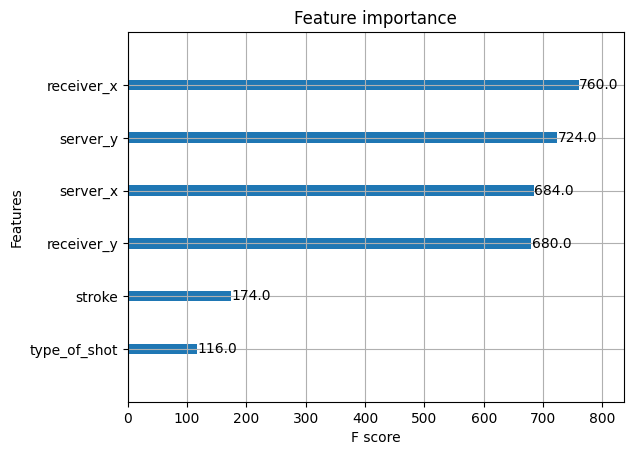

In [8]:
# Train final model with best params
xgb_model = xgb.XGBClassifier(**best_params, use_label_encoder = True, enable_categorical = True)
xgb_model.fit(train_X, train_y)

plot_importance(xgb_model, importance_type='weight')

In [9]:
# Repeat process for XGBoost, predicting only with final rally
test_data_final_stroke = test_data.groupby("rallyid").strokeid.max().reset_index()
test_X_xgb = pd.merge(test_data, test_data_final_stroke)[xgb_model_data_cols].astype({"stroke":'category', "type_of_shot":'category'}) 
test_y_xgb = test_data[["rallyid", "ServerWinsPoint"]].drop_duplicates().reset_index(drop = True)

test_y_outcomes = test_data.ServerWinsPoint
pred_y = xgb_model.predict(test_X_xgb)
pred_proba_y = xgb_model.predict_proba(test_X_xgb)

In [10]:
# Caluclate Log Loss and Brier Score
xgboost_lloss = log_loss(test_y_xgb.ServerWinsPoint, pred_y)
xgboost_brier = brier_score_loss(test_y_xgb.ServerWinsPoint, pred_proba_y[:, 1])

print(f"XGBoost Event Model Log Loss: {xgboost_lloss}")
print(f"XGBoost Event Model Brier Score: {xgboost_brier}")

XGBoost Event Model Log Loss: 13.862943611198906
XGBoost Event Model Brier Score: 0.24270232940998177


In [11]:
# Calculate xSPW values, sums
test_y_xgb["prob"] = pred_proba_y[:, 1]
test_y_xgb["xSPW"] = test_y_xgb["ServerWinsPoint"] - test_y_xgb["prob"]

xgb_xSPW = pd.merge(points_data[["rallyid", "server"]], test_y_xgb).groupby("server").xSPW.sum().reset_index()
xgb_xSPW

,server,xSPW
0,Djokovic,0.797742
1,Nadal,-1.133754


# Neural Nets

In [12]:
# Set X and y columns
nnet_model_data_cols = ["rallyid", "strokeid", 'stroke', 'type_of_shot', 'time_diff','server_x', 'server_y', 'receiver_x', 'receiver_y',
                   'server_distance_from_baseline', 'receiver_distance_from_baseline']

train_X = train_data[nnet_model_data_cols].astype({"stroke":'category', "type_of_shot":'category'}) 
test_X = test_data[nnet_model_data_cols].astype({"stroke":'category', "type_of_shot":'category'}) 

train_y = train_data[["rallyid", "ServerWinsPoint"]].drop_duplicates().reset_index(drop = True)
test_y = test_data[["rallyid", "ServerWinsPoint"]].drop_duplicates().reset_index(drop = True)

In [13]:
def perform_ohc_transformation(data, cols_to_encode, one_hot_encoder = None):
    """
    Purpose: With raw dataset, transform input columns with one-hot encoder

    Input(s): 
        data (pd.DataFrame): Raw dataset
        cols_to_encode (list): contains names of column in input
        one_hot_encoder (NoneType or Sklearn object): default None, creates or uses preexisting one-hot encoder object

    Output(s):
        preprocessed_data (NumPy array): Dataset with one-hot encoded columns
        one_hot_encoder (Sklearn object): Newly created or existing OHC object
    """

    # Check if OHC object exists
    if one_hot_encoder is None:
        # Initialize OHC Object
        one_hot_encoder = OneHotEncoder(sparse=False, drop = "first", handle_unknown = "ignore")

        # Fit the encoder to the specified columns
        encoded_columns = one_hot_encoder.fit_transform(data[cols_to_encode])

    else:
        # Fit the encoder to the specified columns
        encoded_columns = one_hot_encoder.transform(data[cols_to_encode])
        
    # Convert encoded columns to DataFrame
    encoded_cols = pd.DataFrame(encoded_columns, columns=one_hot_encoder.get_feature_names_out(cols_to_encode))
        
    # Concatenate encoded columns with the original DataFrame
    preprocessed_data = pd.concat([data.drop(columns=cols_to_encode), encoded_cols], axis=1)
    
    return(preprocessed_data, one_hot_encoder)

In [14]:
def prepare_nnet_data(x_train, y_train, ohc_cols, fit_ohc=None):
    """
    Purpose: Prepare the data for training an LSTM model via OHC and segmenting data into lists of arrays

    Input(s):
        x_train (pd.DataFrame): Contains training data
        y_train (pd.DataFrame): Contains training data labels
        ohc_cols (list): List of columns to be one-hot encoded
        fit_ohc (OneHotEncoder): Pre-fitted OneHotEncoder. Default None, creates a new encoder if None

    Output(s):
        tuple: A tuple containing preprocessed data with padding (X, y), plus fitted OneHotEncoder.
    """
    
    # Perform one-hot encoding
    if fit_ohc is None:
        X_tr, encoder = perform_ohc_transformation(x_train, ohc_cols)
    else:
        X_tr, encoder = perform_ohc_transformation(x_train, ohc_cols, one_hot_encoder=fit_ohc)


    # Prepare the data for LSTM
    X = []
    y = []
    rallies = X_tr["rallyid"].unique()

    # Iterating through unique rallies
    for rally in rallies:
        # Select all events
        event_data = X_tr[X_tr["rallyid"] == rally]
        outcome = y_train[y_train["rallyid"] == rally]

        # Convert data into own array, add to list of data
        X.append(event_data.drop(["rallyid", "strokeid"], axis=1).values)
        y.append(outcome["ServerWinsPoint"].values[0])

    y = np.array(y)
    return (X, y, encoder)

In [15]:
# Specify columns to be encoded
columns_to_encode = ['type_of_shot', 'stroke']
X_nnet, y_nnet, ohc = prepare_nnet_data(train_X, train_y, columns_to_encode)

In [16]:
# Define number of timestamps, features to use in LSTM model
max_strokes_per_rally = train_X.groupby("rallyid").strokeid.count().reset_index().strokeid.max()
num_features = len(X_nnet[0][0])

# Pad preprocessed data to go up to max number of timestamps 
X_nnet_padded = pad_sequences(X_nnet, padding = 'post', dtype = 'float32', value = -100, maxlen = max_strokes_per_rally)

In [17]:
# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=909)
fold = 1

log_loss_scores = []

# Iterating through each fold
for train_index, test_index in kf.split(X_nnet_padded):
    print(f'Fold {fold}')
    X_train, X_test = X_nnet_padded[train_index], X_nnet_padded[test_index]
    y_train, y_test = y_nnet[train_index], y_nnet[test_index]

    # Defining the LSTM Sequential model (simple, heavily regularized)
    model = Sequential()
    model.add(LSTM(5, activation='relu', recurrent_dropout=0.1, 
              kernel_regularizer=l2(0.01), input_shape = (max_strokes_per_rally, num_features)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='loss', patience=5, min_delta = 0.5,restore_best_weights=True)
    
    # Train the model with callback
    model.fit(X_train, y_train, epochs=25, batch_size=16, callbacks=[early_stopping])

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy for fold {fold}: {accuracy * 100:.2f}%')
    
    # Predict the outcome
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    print(f'Predicted outcomes for fold {fold}: {y_pred.flatten()}')

    log_loss_scores.append(loss)
    fold += 1

Fold 1
Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4236 - loss: 2.2916
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6562 - loss: 0.8886
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6562 - loss: 0.8846
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6562 - loss: 0.9076 
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6562 - loss: 0.8750 
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6562 - loss: 0.8705 
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6562 - loss: 0.8661 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.8095 - loss: 0.8782
Test Accuracy for fold 1: 80.95%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Predicted outcomes for fold 1: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Fold 2
Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6232 - loss: 0.8933
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6710 - loss: 0.8849 
Epoch 3/25
6/6 ━━━━━

In [18]:
# Log-Loss as mean across all folds
print(f"LSTM Model, Mean CV Log-Loss: {np.mean(log_loss_scores)}")

LSTM Model, Mean CV Log-Loss: 0.9839289426803589


# Train Final Model, Get Predictions

In [19]:
# Retrain model using all sequences
model = Sequential()
model.add(LSTM(5, activation='relu', recurrent_dropout=0.1, 
              kernel_regularizer=l2(0.01), input_shape = (max_strokes_per_rally, num_features)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='loss', patience=5, min_delta = 0.5, restore_best_weights=True)
    
model.fit(X_nnet_padded, y_nnet, epochs=25, batch_size=16, callbacks=[early_stopping])

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7622 - loss: 0.8842
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7622 - loss: 0.8706
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7622 - loss: 0.8630
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7622 - loss: 0.8525
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7622 - loss: 0.8352
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7622 - loss: 0.8196


In [20]:
# Preprocess test set
test_X_nnet, test_y_nnet, ohc = prepare_nnet_data(test_X, test_y, columns_to_encode, ohc)
test_X_nnet_padded = pad_sequences(test_X_nnet, padding = 'post', dtype = 'float32', value = -100, maxlen = max_strokes_per_rally)

In [21]:
# Calculate test set preds, Log Loss, Brier Score
test_y["prob"] = model.predict(test_X_nnet_padded)
test_y["xSPW"] = test_y.ServerWinsPoint - test_y.prob

print(f"LSTM Model Log-Loss: {log_loss(test_y['ServerWinsPoint'], test_y['prob'])}")
print(f"LSTM Model Brier Score: {brier_score_loss(test_y['ServerWinsPoint'], test_y['prob'])}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
LSTM Model Log-Loss: 0.6897888998977844
LSTM Model Brier Score: 0.2483212559170123


In [22]:
# Recalculate xSPW values, sums
player_xSPW = pd.merge(points_data[["rallyid", "server"]], test_y)
player_summary_final_games = player_xSPW.groupby("server").xSPW.sum().reset_index()
player_summary_final_games

,server,xSPW
0,Djokovic,1.889598
1,Nadal,-0.045445


In [23]:
# Save model
model.save(output_path + 'xspw_prototype.h5')

In [24]:
def create_cumulative_sequences(data, length, n, m):
    """
    Purpose: Create cumulative sequences of event data with padding

    Input(s):
        data (list): A list of sequences containing event data
        length (int): The maximum length of the sequences after padding
        n (int): The number of sequences
        m (int): The number of features in each sequence

    Output(s):
        events_component (np.ndarray): An array of padded cumulative event sequences with the shape (n, length, m).
    """
    
    # Initialize list to hold cumulative event sequences
    event_components = []

    # Iterate through each sequence in the data
    for ind in range(len(data)):
        for event_ind in range(len(data[ind])):
            # Create a cumulative sequence up to the current event
            sequence = [data[ind][:event_ind + 1]]
            
            # Pad the sequence to the specified length
            padded_sequence = pad_sequences(sequence, padding='post', dtype='float32', value=-100, maxlen=length)
            event_components.append(padded_sequence)
    
    # Reshape the event components to the desired shape
    event_components = np.array(event_components).reshape(n, length, m)

    return event_components

In [25]:
# Convert test set into list of cumulative padded sequences for each event
num_samples = test_X.shape[0]
n_features = test_X_nnet[0].shape[1]

X_test_sequential = create_cumulative_sequences(test_X_nnet, max_strokes_per_rally, num_samples, n_features)

In [26]:
# For each sequence, predict probabilty of server winning at each event
predict_df = test_X.copy()
predict_df["prob"] = model.predict(X_test_sequential)

predict_df.to_csv("event_predictions.csv", index = False)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
